In [27]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from copy import deepcopy
import time
import matplotlib.pyplot as plt
import random
from datetime import datetime

In [2]:
from src.data.make_dataset import make_dataset
from src.data.dataset_loaders import AerialCarsDatasetLoader
from src.data.image_loaders import AerialCarsFixedSizeImageLoader
from src.features.pipelines import RawImageToFeatures
from src.features.processors import RotateToHorizontal, Resize
from src.features.descriptors import HOGDescriptor, LBPDescriptor
from src.models.detectors import SliderDetector
from src.data.sliders import SlidingWindow

In [18]:
BND_BOX_SIZE = (256, 256)
SLIDER_STEP_SIZE = 32
DATASET_PATH = '../../data/interim/aerial-cars-dataset2/'
VAL_DATASET_PATH = '../../data/interim/aerial-cars-dataset2/val/'
WORKERS = 7

In [4]:
dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsFixedSizeImageLoader(
        bnd_box_size=BND_BOX_SIZE
    )
)

process_pipeline=RawImageToFeatures(
        processors=[],
        descriptors=[
            HOGDescriptor(
                orientations = 9,
                cells_per_block = (2, 2),
                pixels_per_cell = (8, 8),
                multichannel = True,
                visualize = True
            ),
            LBPDescriptor(
                bins = 256,
                range = (0, 256)
            )
        ]
    )

## Features dataset

In [5]:
start_time = time.time()

data = make_dataset(
    input_folder_filepath=DATASET_PATH,
    output_filepath='output_path',
    dataset_loader=dataset_loader,
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    process_pipeline=process_pipeline,
    negative_images_size=BND_BOX_SIZE,
    negative_examples_size=0.3,
    workers=WORKERS,
    verbose=True
)

print()
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 475/475 [00:00<00:00, 1139.99it/s]

--- 98.59539079666138 seconds ---


## SVM training

In [6]:
X = list(map(lambda x: x[1], data))
y = list(map(lambda x: x[2], data))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# clf = make_pipeline(SVC(gamma='auto'))
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       151
           1       0.98      0.57      0.72        74

    accuracy                           0.85       225
   macro avg       0.90      0.78      0.81       225
weighted avg       0.87      0.85      0.84       225



## Test images loading

In [7]:
images = dataset_loader.load_dataset(
    input_folder_filepath=VAL_DATASET_PATH,
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    verbose=True
)

100%|██████████| 6/6 [00:00<00:00,  7.90it/s]


In [8]:
len(images)

3

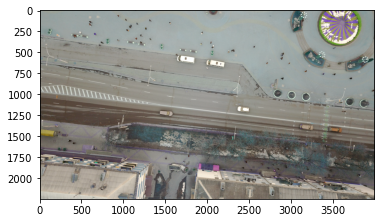

In [9]:
plt.imshow(images[0].image)

## Sliding detection

In [22]:
sliding_window = SlidingWindow(
    step_size=SLIDER_STEP_SIZE,
    window_size=BND_BOX_SIZE
)

In [23]:
slider_detector = SliderDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=clf
)

### Parallel approach

In [24]:
start_time = time.time()

(image, bnd_boxes) = slider_detector(deepcopy(images[1]), WORKERS, True)

print()
print("--- %s seconds ---" % (time.time() - start_time))


--- 1251.548245191574 seconds ---


In [25]:
len(bnd_boxes)

32

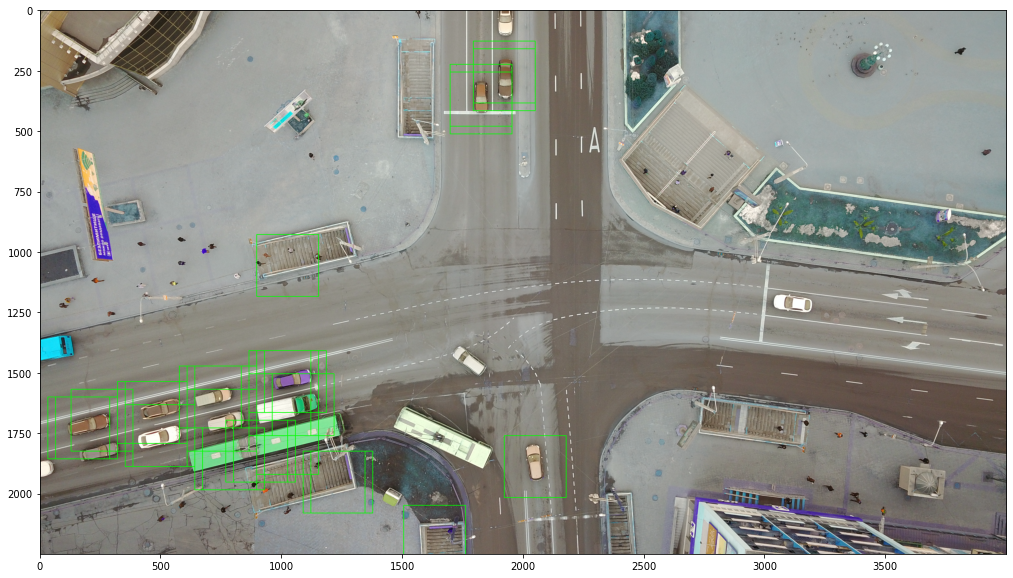

In [29]:
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.savefig('./2-3-detection-'+datetime.now().strftime("%d_%m_%Y_%H_%M_%S")+'.jpg')